In [1]:
%load_ext lab_black
%config Completer.use_jedi = False

In [ ]:
%%time
import pandas as pd
from Grid_Tuning import grid_trading
from tqdm import tqdm 
import time

FILENAME = "Binance_BTC_1m.csv"
data = pd.read_csv(FILENAME)
optimization=[]
for interval_for_rsv in tqdm(range(10, 60)):
    records_df, final_profit = grid_trading(
        data, INTERVALS_FOR_RSV=interval_for_rsv, INTERVAL_FOR_BOUNDS=9 * 24 * 60, SD_PARAMETER=2,
    )
    optimization.append([final_profit, interval_for_rsv, 9, 2])
    print(time.ctime())
# optimization=[]
# for interval_for_rsv in tqdm(range(10, 60)):
#     for interval_for_bounds in range(2, 20):
#         for sd_parameter in range(2,5):
#             records_df, final_profit = grid_trading(
#                 data, INTERVALS_FOR_RSV=interval_for_rsv, INTERVAL_FOR_BOUNDS=interval_for_bounds * 24 * 60, SD_PARAMETER=sd_parameter,
#             )
#             optimization.append([final_profit, interval_for_rsv, interval_for_bounds, sd_parameter])
#             print(time.ctime())

  2%|▏         | 1/50 [00:14<11:30, 14.10s/it]

Thu May  6 11:24:14 2021


  4%|▍         | 2/50 [00:33<13:44, 17.18s/it]

Thu May  6 11:24:33 2021


  6%|▌         | 3/50 [00:49<13:06, 16.74s/it]

Thu May  6 11:24:49 2021


  8%|▊         | 4/50 [01:05<12:37, 16.46s/it]

Thu May  6 11:25:06 2021


 10%|█         | 5/50 [01:23<12:47, 17.06s/it]

Thu May  6 11:25:24 2021


 12%|█▏        | 6/50 [01:41<12:40, 17.29s/it]

Thu May  6 11:25:41 2021


 14%|█▍        | 7/50 [01:57<12:08, 16.95s/it]

Thu May  6 11:25:58 2021


 16%|█▌        | 8/50 [02:13<11:37, 16.60s/it]

Thu May  6 11:26:13 2021


 18%|█▊        | 9/50 [02:33<12:04, 17.68s/it]

Thu May  6 11:26:34 2021


 20%|██        | 10/50 [03:01<13:52, 20.81s/it]

Thu May  6 11:27:01 2021


In [9]:
# optimization_df = pd.DataFrame(
#     optimization,
#     columns=["FinalProfit", "IntervalForRSV", "IntervalForBounds", "SDParameter",],
# )
# optimization_df.to_excel("Training.xlsx")
optimization_df = pd.read_excel("Training.xlsx")
optimization_df

,FinalProfit,IntervalForRSV,IntervalForBounds,SDParameter
0,30883,10,2,2
1,18286,10,2,3
2,14880,10,2,4
3,49662,10,3,2
4,19987,10,3,3
...,...,...,...,...
2695,14743,59,18,3
2696,18259,59,18,4
2697,30286,59,19,2
2698,14175,59,19,3


In [19]:
df = optimization_df[
    optimization_df["FinalProfit"] == optimization_df["FinalProfit"].max()
]
SDParameter = df["SDParameter"].unique()
IntervalForBounds = df["IntervalForBounds"].unique()
IntervalForRSV = df["IntervalForRSV"].unique()
FinalProfit = df["FinalProfit"].unique()

In [21]:
SDParameter

array([2], dtype=int64)

In [22]:
IntervalForBounds

array([9], dtype=int64)

In [18]:
IntervalForRSV

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
      dtype=int64)

In [20]:
FinalProfit

array([51327], dtype=int64)

In [6]:
%load_ext lab_black
%config Completer.use_jedi = False
import pandas as pd

f = "Binance_BTC_1m.csv"
data = pd.read_csv(f)
data
N = 24 * 60
M = 2
CLOSE = "Close"
TIMESTAMP = "TimeStamp"


def calc_RSV(prices, n=9):
    C = prices
    H = prices.rolling(n).max()
    L = prices.rolling(n).min()
    RSV = (C - L) / (H - L)
    return RSV


RSV = calc_RSV(data["Close"])
data["RSV"] = RSV

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [13]:
def calc_bbands(prices, n=N, m=M):
    middle_vals = prices.rolling(n).mean()
    std_vals = prices.rolling(n).std(ddof=0)
    upper_vals = middle_vals + m * std_vals
    lower_vals = middle_vals - m * std_vals
    return upper_vals, middle_vals, lower_vals


upper, middle, lower = calc_bbands(data["Close"])
data.loc[:, "boll_upper"] = upper
# data['boll_middle'] = middle
data.loc[:, "boll_lower"] = lower
data = data.dropna()
data.reset_index(drop=True, inplace=True)
data.loc[:, "range"] = data.loc[:, "boll_upper"] - data.loc[:, "boll_lower"]
data["range"].max() - data["range"].min()
print(data["range"].max(), data["range"].min())

11266.533238417556 230.090456891965


In [17]:
maxv, minv = data["range"].max(), data["range"].min()
rate = pow(maxv / minv, 1 / 19)
rate - 1

0.22727438004043043

In [6]:
def get_final_profit(df):
    temp = df.tail(1)
    final_profit = temp.iloc[0]["Profit"]
    return final_profit


get_final_profit(df)

20947

In [83]:
# data1 = data[data["Close"] > data["boll_upper"]]
# data1

In [84]:
R = 0.005
BEGINNING_CASH = 100000
FEE = 0.005
records = []
profit = 0
cash = BEGINNING_CASH
n = 0
last_price = 0
upper_bound = data.loc[0]["boll_upper"]
lower_bound = data.loc[0]["boll_lower"]
start_index = 0
r = 0.005
BOLL_UPPER = "boll_upper"
BOLL_LOWER = "boll_lower"

In [85]:
%%time
for index, row in data.iterrows():
    time = row[TIMESTAMP]
    price = row[CLOSE]
    upper_bound = row[BOLL_UPPER]
    lower_bound = row[BOLL_LOWER]
    trading_buying_price = price * (1 + FEE)
    trading_selling_price = price * (1 - FEE)

    if n == 0 and (
        trading_buying_price < upper_bound
        or trading_buying_price < last_price * (1 - R)
    ):
        if trading_buying_price > lower_bound:
            last_price = trading_buying_price
            n = cash // trading_buying_price
            if n > 0:
                cash -= n * trading_buying_price
                profit = cash - BEGINNING_CASH
                records.append(
                    [
                        "Buying",
                        round(trading_buying_price),
                        n,
                        round(cash),
                        round(profit),
                        lower_bound,
                        upper_bound,
                        time
                    ]
                )
    
    elif n > 0 and (
        trading_selling_price > lower_bound
        or trading_selling_price > last_price * (1 + R)
    ):
        if trading_selling_price < upper_bound and trading_selling_price>last_price:
            last_price = trading_selling_price
            cash += n * trading_selling_price
            profit = cash - BEGINNING_CASH
            n = 0
            records.append(
                [
                    "Selling",
                    round(trading_selling_price),
                    n,
                    round(cash),
                    round(profit),
                    lower_bound,
                    upper_bound,
                    time
                ]
            )

CPU times: user 9.89 s, sys: 92.9 ms, total: 9.99 s
Wall time: 10.3 s


In [79]:
def check_last_row(records_df):
    temp = records_df.tail(1)
    last_action = temp.iloc[0]["Action"]
    if last_action == "Buying":
        records_df = records_df.iloc[:-1, :]
    return records_df

In [86]:
records_df = pd.DataFrame(
    records,
    columns=[
        "Action",
        "Price",
        "n",
        "Cash",
        "Profit",
        "LowerBound",
        "UpperBound",
        "Hour",
    ],
)
# records_df.to_excel("GridActions03.xlsx")
records_df = check_last_row(records_df)
records_df

,Action,Price,n,Cash,Profit,LowerBound,UpperBound,Hour
0,Buying,14591,6.0,12452,-87548,13697.116169,14591.966275,05/11/20 19:20
1,Selling,14608,0.0,100102,102,13714.678840,14611.832396,05/11/20 19:50
2,Buying,15027,6.0,9940,-90060,13733.006106,15100.451533,06/11/20 1:31
3,Selling,15040,0.0,100180,180,13733.542496,15113.093407,06/11/20 1:43
4,Buying,15123,6.0,9443,-90557,13733.098010,15129.061407,06/11/20 1:55
...,...,...,...,...,...,...,...,...
221,Selling,63649,0.0,121166,21166,61010.789521,64470.568340,14/04/21 12:41
222,Buying,64309,1.0,56857,-43143,61016.439054,64469.904112,14/04/21 12:42
223,Selling,64379,0.0,121236,21236,61488.006606,64456.706769,14/04/21 14:14
224,Buying,64270,1.0,56966,-43034,62203.666800,64414.138644,14/04/21 16:47


<AxesSubplot:>

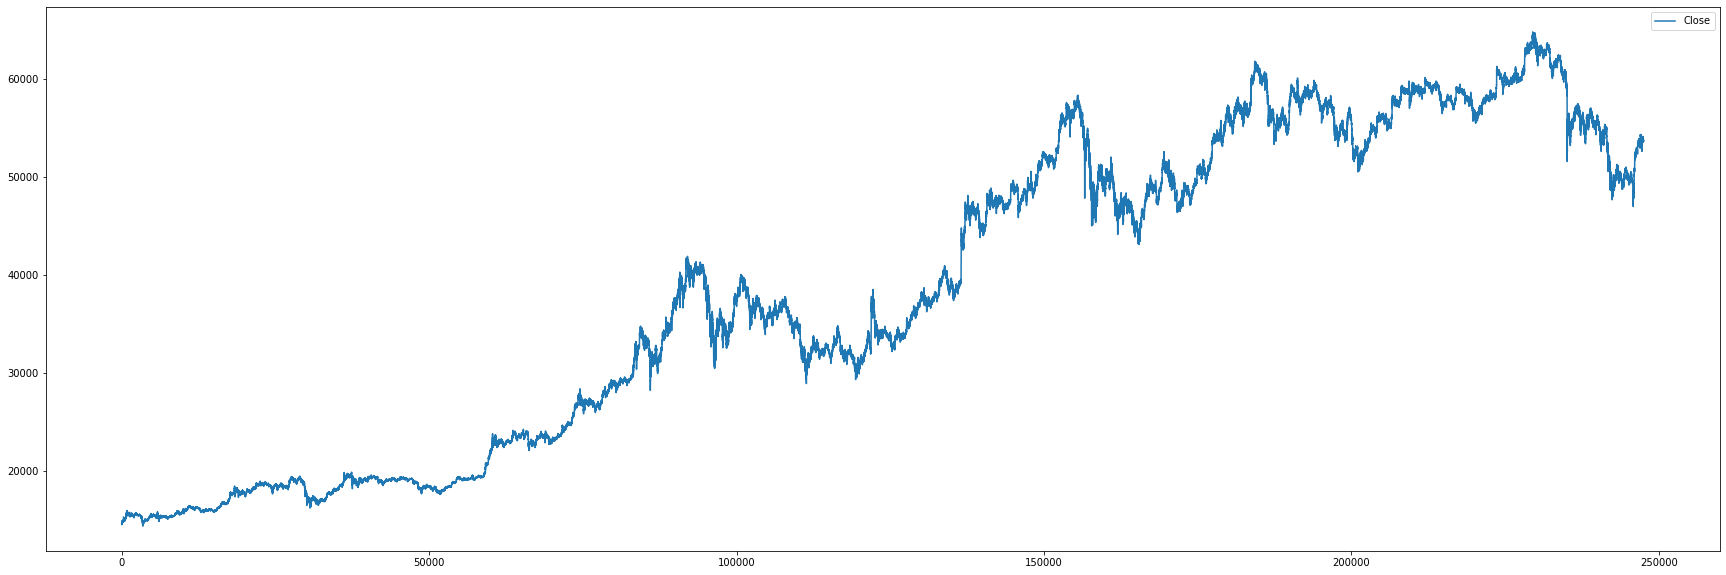

In [58]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, ax = plt.subplots(figsize=(30, 10))
# plt.ylim(0, 100)
data[[CLOSE]].plot(ax=ax)

In [10]:
# %%time
# import numpy as np
# from tqdm import tqdm
# optimization_r=[]
# fee = 0.002
# for r in tqdm(np.arange(fee,0.1,0.001)):
#     records=[]
#     profit=0
#     cash=100000
#     n=0
#     last_price=0
#     for lower_bound in range(30000, 60000,10000):
#         upper_bound=lower_bound+10000
# #         print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}, Profit: {profit}, Cash: {cash}, Number of coins: {n}, Last Price: {last_price}")
#         profit,records,cash,n, last_price=get_profit(r, records,profit,cash, lower_bound, upper_bound,n, last_price,)
#     optimization_r.append([r, profit])
# optimization_r_df = pd.DataFrame(optimization_r, columns=["Rate", "Profit"])
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# # print(optimization_r_df)
# optimization_r_df[optimization_r_df["Profit"] == optimization_r_df["Profit"].max()]

In [11]:
# optimization_r_df

In [11]:
%%time
r=0.042
fee = 0.002
records=[]
profit=0
cash=100000
n=0
last_price=0
for lower_bound in range(30000, 60000,10000):
    upper_bound=lower_bound+10000
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}, Profit: {profit}, Cash: {cash}, Number of coins: {n}, Last Price: {last_price}")
    profit,records,cash,n, last_price=get_profit(r, records,profit,cash, lower_bound, upper_bound,n, last_price,)
pd.set_option("display.max_rows", None, "display.max_columns", None)
records_df = pd.DataFrame(
    records, columns=["Action", "Price", "n", "Cash", "Profit", "Hour"]
)
print(profit)
records_df

Lower Bound: 30000, Upper Bound: 40000, Profit: 0, Cash: 100000, Number of coins: 0, Last Price: 0
Lower Bound: 40000, Upper Bound: 50000, Profit: 26877.630059999996, Cash: 126877.63006, Number of coins: 0, Last Price: 31316.79
Lower Bound: 50000, Upper Bound: 60000, Profit: 36090.816899999976, Cash: 136090.81689999998, Number of coins: 0, Last Price: 41753.86
47569.182579999964
Wall time: 1min 4s


,Action,Price,n,Cash,Profit,Hour
0,Buying,-30099,3.0,9522,-90478,2021-01-02 20:20:00
1,Selling,31541,0.0,103957,3957,2021-01-02 21:59:00
2,Buying,-30200,3.0,13175,-86825,2021-01-04 18:46:00
3,Selling,31646,0.0,107923,7923,2021-01-04 22:00:00
4,Buying,-30275,3.0,16915,-83085,2021-01-05 13:52:00
5,Selling,31567,0.0,111428,11428,2021-01-05 17:30:00
6,Buying,-30123,3.0,20880,-79120,2021-01-22 06:37:00
7,Selling,31444,0.0,115024,15024,2021-01-22 07:02:00
8,Buying,-30077,3.0,24611,-75389,2021-01-22 08:24:00
9,Selling,31388,0.0,118587,18587,2021-01-22 12:14:00
